In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage
import cv2 as cv
import torch

In [2]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_framework.imagenet.dataloader import get_imagenet_dls

## Get 3 samples from ImageNet

In [3]:
# Lists of best or most interesting shape/texture/background classes
# (Yes, I know all imagenet classes very well by now)
MASKS = [9, 18, 22, 35, 56, 63, 96, 97, 119, 207, 225, 260, 275, 323, 330, 350, 370, 403, 411,
         414, 427, 438, 439, 441, 460, 484, 493, 518, 532, 540, 550, 559, 561, 570, 604, 647,
         688, 713, 724, 749, 751, 756, 759, 779, 780, 802, 814, 833, 841, 849, 850, 859, 869,
         872, 873, 874, 876, 880, 881, 883, 894, 897, 898, 900, 907, 930, 933, 945, 947, 949,
         950, 953, 963, 966, 967, 980]
FOREGROUND = [12, 15, 18, 25, 54, 66, 72, 130, 145, 207, 251, 267, 271, 275, 293, 323, 385,
              388, 407, 409, 427, 438, 439, 441, 454, 461, 468, 482, 483, 486, 490, 492, 509,
              530, 555, 607, 608, 629, 649, 652, 681, 688, 719, 720, 728, 737, 741, 751, 756,
              779, 800, 810, 850, 852, 854, 869, 881, 907, 911, 930, 936, 937, 938, 941, 949,
              950, 951, 954, 957, 959, 963, 966, 985, 987, 992]
BACKGROUNDS = [7, 9, 20, 30, 35, 46, 50, 65, 72, 93, 96, 97, 119, 133, 147, 337, 350, 353, 354,
               383, 429, 460, 693, 801, 888, 947, 949, 952, 953, 955, 958, 970, 972, 973, 974,
               977, 979, 998]

def sample_classes(mode, classes=None):
    if mode == 'random':
        return np.random.randint(0, 1000, 3).tolist()

    elif mode == 'random_same':
        return [np.random.randint(0, 1000)] * 3

    elif mode == 'best_classes':
        return [np.random.choice(MASKS),
                np.random.choice(FOREGROUND),
                np.random.choice(BACKGROUNDS)]

    elif mode == 'fixed_classes':
        return [int(c) for c in classes]

    else:
        assert ValueError("Unknown sample mode {mode}")


# Load fake CGN

In [4]:
classes = sample_classes('random')

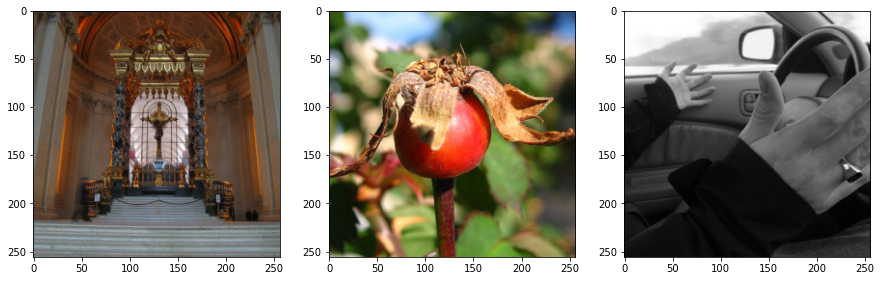

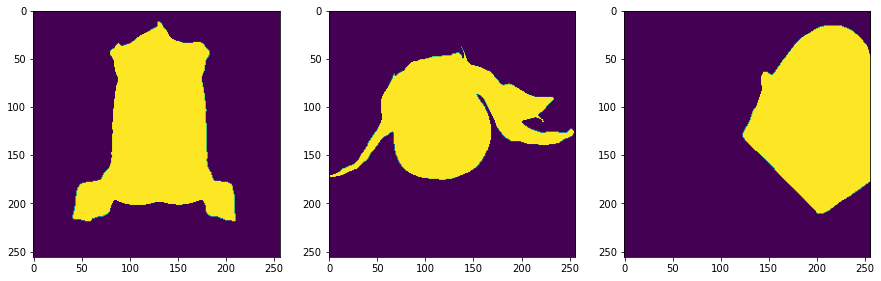

In [10]:
from cgn_framework.imagenet.models.fake_cgn import CGN

cgn = CGN()
_, mask, _, texture, background, _ = cgn(classes, debug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


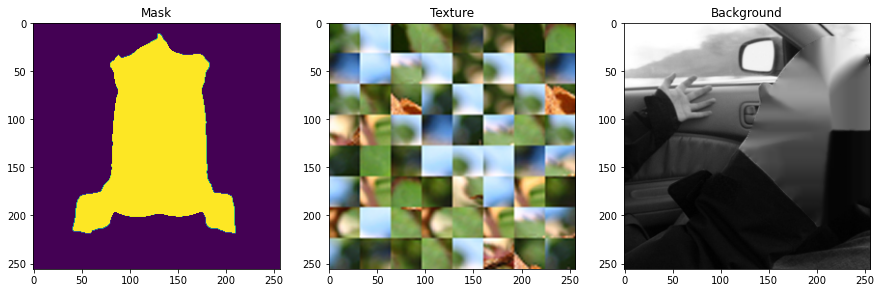

In [11]:
# Plot mask, texture, background
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(mask.squeeze(0).numpy().transpose(1,2,0))
ax[0].set_title('Mask')
ax[1].imshow(texture.squeeze(0).numpy().transpose(1,2,0))
ax[1].set_title('Texture')
ax[2].imshow(background.squeeze(0).numpy().transpose(1,2,0))
ax[2].set_title('Background')
plt.show()

# Inpaint shape to background

In [12]:
from poisson_blending import poissonSeamlessCloning

In [13]:
input_img_source = np.clip(255*texture.squeeze(0).numpy().transpose(1,2,0), 0, 255).astype(np.uint8)
input_img_target = np.clip(255*background.squeeze(0).numpy().transpose(1,2,0), 0, 255).astype(np.uint8)
input_img_mask = mask.squeeze(0).numpy().transpose(1,2,0).astype(np.uint8)

img_out = poissonSeamlessCloning(
    img_source=input_img_source,
    img_target=input_img_target,
    src_mask=input_img_mask,
    offset=(0,0)
)

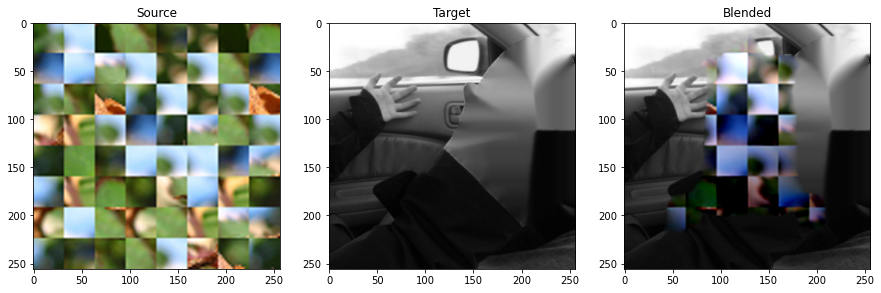

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(input_img_source)
ax[0].set_title('Source')
ax[1].imshow(input_img_target)
ax[1].set_title('Target')
ax[2].imshow(img_out)
ax[2].set_title('Blended')
plt.show()